In [1]:
import csv
import logs
import numpy as np
import pandas as pd
import seaborn as sns
from Bandit import Bandit
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
Bandit_Reward=[1,2,3,4] 
NumberOfTrials: 2000

In [3]:

class EpsilonGreedy(Bandit):
    def __init__(self, p, epsilon=0.1):
        self.epsilon = epsilon
        self.N = len(p)  # Number of bandits
        self.k = np.zeros(self.N)  # Number of times each bandit was chosen
        self.mean_reward = np.zeros(self.N)  # Mean reward of each bandit
        self.total_reward = 0
        self.rewards = []

    def __repr__(self):
        return f"EpsilonGreedy(epsilon={self.epsilon}, N={self.N}, mean_reward={self.mean_reward})"

    def pull(self):
        # Epsilon-greedy algorithm
        if np.random.rand() < self.epsilon:
            # Explore: choose a random bandit
            chosen_bandit = np.random.choice(self.N)
        else:
            # Exploit: choose the bandit with the highest mean reward
            chosen_bandit = np.argmax(self.mean_reward)
        reward = Bandit_Reward[chosen_bandit]  # Simulate the reward
        self.rewards.append((chosen_bandit, reward, "EpsilonGreedy"))
        return chosen_bandit, reward

    def update(self, chosen_bandit, reward):
        self.k[chosen_bandit] += 1
        alpha = 1.0 / self.k[chosen_bandit]
        self.mean_reward[chosen_bandit] += alpha * (reward - self.mean_reward[chosen_bandit])
        self.total_reward += reward

    '''def experiment(self, trials=2000):
        for t in range(1, trials + 1):
            chosen_bandit, reward = self.pull()
            self.update(chosen_bandit, reward)
            self.epsilon /= t ''' # Decay epsilon
    def experiment(self, trials=2000):
        for t in range(1, trials + 1):
            chosen_bandit, reward = self.pull()
            self.update(chosen_bandit, reward)
            self.epsilon = max(self.epsilon / t, 0.01)

    def report(self):
        # Store data in csv
        with open("rewards.csv", "w", newline="") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Bandit", "Reward", "Algorithm"])
            writer.writerows(self.rewards)
        # Print average reward and regret
        optimal_reward = max(Bandit_Reward)
        avg_reward = self.total_reward / sum(self.k)
        avg_regret = optimal_reward - avg_reward
        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Average Regret: {avg_regret:.2f}")


In [4]:
class ThompsonSampling(Bandit):
    def __init__(self, p):
        self.N = len(p)  # Number of bandits
        self.alpha = np.ones(self.N)  # Successes + 1 for each bandit
        self.beta = np.ones(self.N)  # Failures + 1 for each bandit
        self.total_reward = 0
        self.rewards = []

    def __repr__(self):
        return f"ThompsonSampling(N={self.N}, alpha={self.alpha}, beta={self.beta})"
    
    def pull(self):
        # Thompson Sampling algorithm
        sampled_values = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.N)]
        chosen_bandit = np.argmax(sampled_values)
        reward = Bandit_Reward[chosen_bandit]  # Simulate the reward
        self.rewards.append((chosen_bandit, reward, "ThompsonSampling"))
        return chosen_bandit, reward

    '''def update(self, chosen_bandit, reward):
        if reward == 1:
            self.alpha[chosen_bandit] += 1
        else:
            self.beta[chosen_bandit] += 1
        self.total_reward += reward'''
    def update(self, chosen_bandit, reward):
        if reward > 0:
            self.alpha[chosen_bandit] += 1
        else:
            self.beta[chosen_bandit] += 1
        self.total_reward += reward


    def experiment(self, trials=2000):
        for _ in range(trials):
            chosen_bandit, reward = self.pull()
            self.update(chosen_bandit, reward)

    def report(self):
        # Store data in csv
        with open("rewards.csv", "a", newline="") as csvfile:  # Append mode
            writer = csv.writer(csvfile)
            writer.writerows(self.rewards)
        # Print average reward and regret
        optimal_reward = max(Bandit_Reward)
        avg_reward = self.total_reward / (sum(self.alpha) + sum(self.beta) - 2 * self.N)
        avg_regret = optimal_reward - avg_reward
        print(f"Average Reward: {avg_reward:.2f}")
        print(f"Average Regret: {avg_regret:.2f}")


In [5]:
class Visualization():

    def plot1(self, eg_rewards, ts_rewards):
        # Calculate cumulative average rewards for E-Greedy and Thompson Sampling
        eg_cumulative_rewards = np.cumsum([reward for _, reward, _ in eg_rewards])
        ts_cumulative_rewards = np.cumsum([reward for _, reward, _ in ts_rewards])
        
        eg_avg_rewards = eg_cumulative_rewards / (np.arange(len(eg_rewards)) + 1)
        ts_avg_rewards = ts_cumulative_rewards / (np.arange(len(ts_rewards)) + 1)
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(eg_avg_rewards, label="Epsilon-Greedy")
        plt.plot(ts_avg_rewards, label="Thompson Sampling")
        plt.xlabel("Trials")
        plt.ylabel("Average Reward")
        plt.title("Learning Process of E-Greedy and Thompson Sampling")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot2(self, eg_rewards, ts_rewards):
        # Calculate cumulative rewards for E-Greedy and Thompson Sampling
        eg_cumulative_rewards = np.cumsum([reward for _, reward, _ in eg_rewards])
        ts_cumulative_rewards = np.cumsum([reward for _, reward, _ in ts_rewards])
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(eg_cumulative_rewards, label="Epsilon-Greedy")
        plt.plot(ts_cumulative_rewards, label="Thompson Sampling")
        plt.xlabel("Trials")
        plt.ylabel("Cumulative Reward")
        plt.title("Cumulative Rewards of E-Greedy and Thompson Sampling")
        plt.legend()
        plt.grid(True)
        plt.show()


Average Reward: 3.53
Average Regret: 0.47
Average Reward: 1.00
Average Regret: 3.00


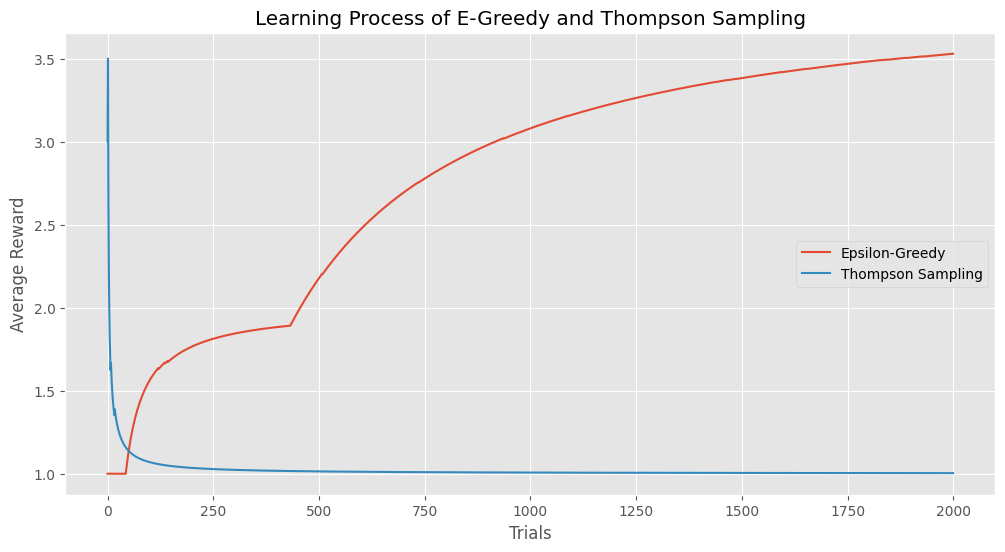

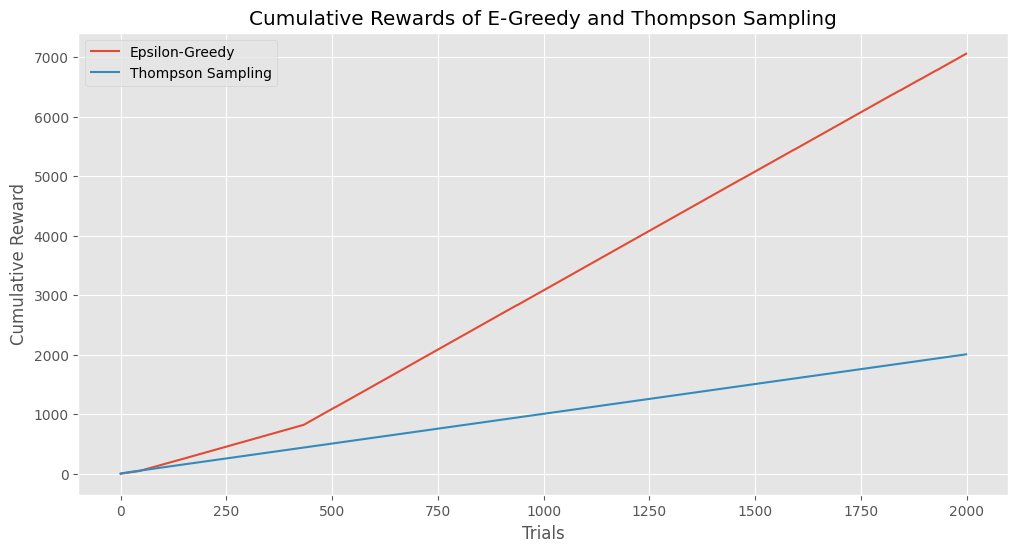

In [6]:
eg = EpsilonGreedy(Bandit_Reward)
ts = ThompsonSampling(Bandit_Reward)

eg.experiment()
ts.experiment()

eg.report()
ts.report()

viz = Visualization()
viz.plot1(eg.rewards, ts.rewards)
viz.plot2(eg.rewards, ts.rewards)

